In [45]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



In [46]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')



In [47]:
print(customers.head())
print(products.head())
print(transactions.head())



  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [48]:
# Merge datasets
transactions_products = pd.merge(transactions, products, on='ProductID', how='left')
merged_data = pd.merge(transactions_products, customers, on='CustomerID', how='left')



In [49]:
# Convert date columns to datetime
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
merged_data['SignupDate'] = pd.to_datetime(merged_data['SignupDate'])



In [50]:
# Create clustering features
# Total spending per customer
customer_spending = merged_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_spending.columns = ['CustomerID', 'TotalSpending']




In [51]:
# Total transactions per customer
customer_transactions = merged_data.groupby('CustomerID')['TransactionID'].count().reset_index()
customer_transactions.columns = ['CustomerID', 'TotalTransactions']



In [52]:
# Days since signup
merged_data['DaysSinceSignup'] = (merged_data['TransactionDate'] - merged_data['SignupDate']).dt.days
average_tenure = merged_data.groupby('CustomerID')['DaysSinceSignup'].mean().reset_index()
average_tenure.columns = ['CustomerID', 'AverageDaysSinceSignup']



In [53]:
# Combine clustering features
clustering_data = customer_spending.merge(customer_transactions, on='CustomerID')
clustering_data = clustering_data.merge(average_tenure, on='CustomerID')




In [54]:
# Extract features for clustering
features = clustering_data[['TotalSpending', 'TotalTransactions', 'AverageDaysSinceSignup']]



In [55]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [56]:
# Perform KMeans clustering for different numbers of clusters
db_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_features)
    db_score = davies_bouldin_score(scaled_features, clusters)
    db_scores.append((n_clusters, db_score))




In [57]:
# Find the optimal number of clusters based on the Davies-Bouldin Index
optimal_clusters = min(db_scores, key=lambda x: x[1])



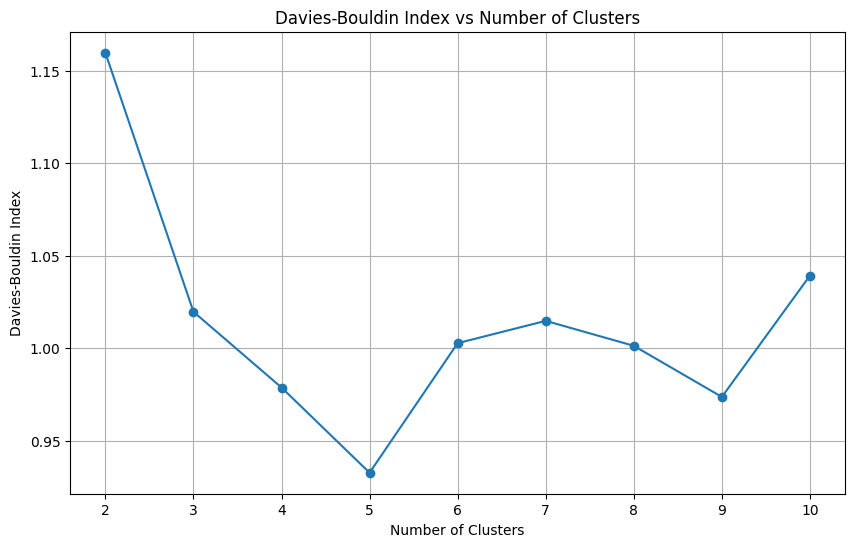

In [58]:
# Visualize the Davies-Bouldin scores
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in db_scores], [x[1] for x in db_scores], marker='o')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()



In [59]:
# Perform clustering with the optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_clusters[0], random_state=42, n_init=10)
clustering_data['Cluster'] = final_kmeans.fit_predict(scaled_features)



In [60]:
# Display clustering results
print("Optimal Number of Clusters:", optimal_clusters[0])
print("Davies-Bouldin Index for Optimal Clusters:", optimal_clusters[1])
print(clustering_data.head())


Optimal Number of Clusters: 5
Davies-Bouldin Index for Optimal Clusters: 0.9327014928324562
  CustomerID  TotalSpending  TotalTransactions  AverageDaysSinceSignup  \
0      C0001        3354.52                  5                 701.800   
1      C0002        1862.74                  4                 874.500   
2      C0003        2725.38                  4                  85.250   
3      C0004        5354.88                  8                 663.875   
4      C0005        2034.24                  3                 673.000   

   Cluster  
0        4  
1        4  
2        1  
3        2  
4        4  


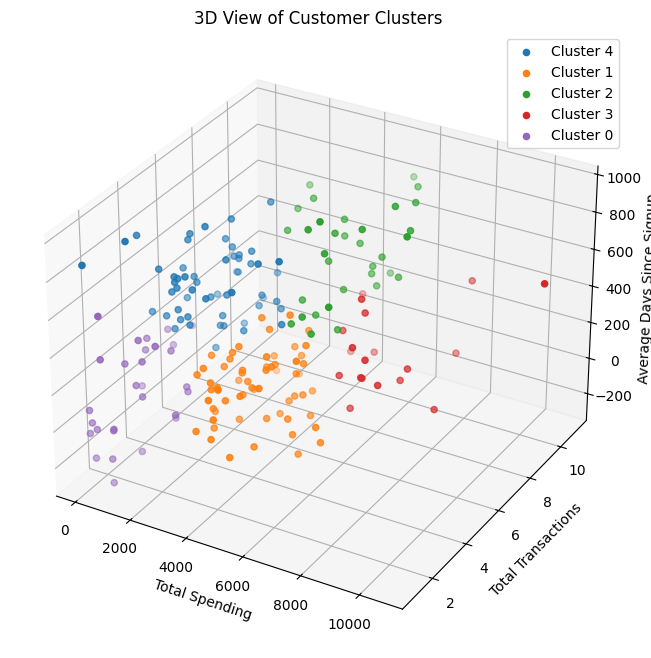

In [61]:

# 3D Scatter plot of clusters
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for cluster in clustering_data['Cluster'].unique():
    cluster_data = clustering_data[clustering_data['Cluster'] == cluster]
    ax.scatter(
        cluster_data['TotalSpending'],
        cluster_data['TotalTransactions'],
        cluster_data['AverageDaysSinceSignup'],
        label=f'Cluster {cluster}'
    )

ax.set_title('3D View of Customer Clusters')
ax.set_xlabel('Total Spending')
ax.set_ylabel('Total Transactions')
ax.set_zlabel('Average Days Since Signup')
ax.legend()
plt.show()